In [1]:
import numpy as np

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from gproc.elliptic import ess_samples_probit
from gproc.metropolis_hastings import mh, mh_step
from gproc.generative import sample_at_x
from gproc.kernels import *
from gproc.laplace import laplace_approximation_probit, chol_inverse
from gproc.approx_marginal_is import importance_sampler
from gproc.joint_sampler import joint_sampler

In [2]:
N = 50 # Data size
D = 1 # Data dimension

x = np.random.normal(0, 1, N * D).reshape(-1, D) # Reshape to N x D matrix
true_lengthscale = 1
true_variance = 1
y, prob_y, f = sample_at_x(x, kernel_fcn = squared_exponential, kernel_params = {'lengthscale': true_lengthscale, 'variance': true_variance})

lap_kernel = SquaredExponential(lengthscale = true_lengthscale, variance = true_variance)

gram = lap_kernel.make_gram(x, x)
inverse_gram = chol_inverse(gram)

In [3]:
# Get approximation to latent function posterior
laplace_mean, df_ll, laplace_cov, objective_history, converged = laplace_approximation_probit(y, inverse_gram)

print(f'Converged: {converged}')

marg_0 = importance_sampler(y, x, laplace_mean, laplace_cov, 100)
marg_0

Converged: True


-144.69006542377628

In [4]:
Kernel = SquaredExponential
th_0 = np.array([np.log(true_lengthscale), np.log(true_variance)])
f_arr, th_arr, marg_arr, move_arr, acc_rate_hist, cov_scale_hist, inverse_gram_arr = joint_sampler(5000, y, x, Kernel, th_0, marg_0, cov=np.eye(th_0.shape[0]), N_imp=64, hyper_burn_in=1000, ess_burn_in=1, verbose=True)

Sampling hyperparameters


 30%|███████████████████████                                                      | 1501/5000 [00:40<02:23, 24.39it/s]/home/tt21864/Documents/Bristol/Semester 2/Group Project/gproc/src/gproc/metropolis_hastings.py:54: RuntimeWarning: covariance is not positive-semidefinite.
  th_new = np.random.multivariate_normal(th_old, cov, 1)[0]
100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:43<00:00, 30.57it/s]


Burning in proposal latent function for ELL-SS algorithm
Sampling latent functions


100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [01:08<00:00, 58.21it/s]


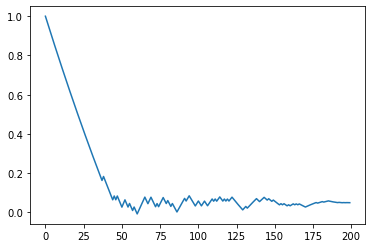

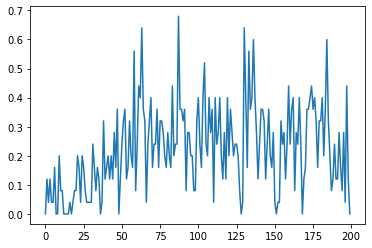

In [5]:
plt.plot(cov_scale_hist)
plt.show()
plt.plot(acc_rate_hist)
plt.show()

Acceptance rate = 22.48


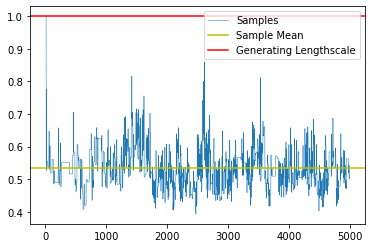

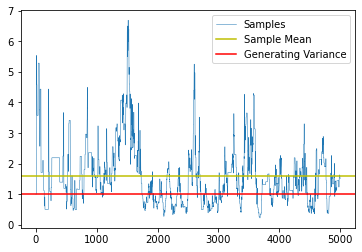

In [6]:
print(f'Acceptance rate = {move_arr.mean()*100}')

plt.plot(np.exp(th_arr[:, 0]), label = 'Samples', linewidth = 0.5)
plt.axhline(y = np.mean(np.exp(th_arr[:, 0])), c = 'y', label = 'Sample Mean')
plt.axhline(y = true_lengthscale, label = 'Generating Lengthscale', c = 'r')
plt.legend()
plt.show()

plt.plot(np.exp(th_arr[:, 1]), label = 'Samples', linewidth = 0.5)
plt.axhline(y = np.mean(np.exp(th_arr[:, 1])), c = 'y', label = 'Sample Mean')
plt.axhline(y = true_variance, label = 'Generating Variance', c = 'r')
plt.legend()
plt.show()

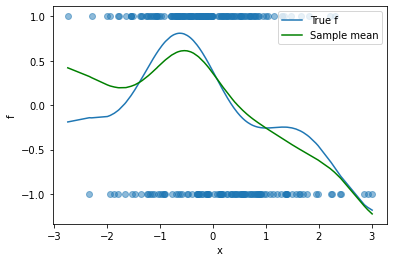

In [7]:
sort_ix = np.argsort(x.reshape(-1))

plt.xlabel('x')
plt.ylabel('f')
for i in range(f_arr.shape[0], 100):
    plt.plot(x[sort_ix], f_arr[i, :][sort_ix], c = 'r', linewidth = 0.1, alpha = 0.8)
    
plt.plot(x[sort_ix], f[sort_ix], label='True f')
plt.plot(x[sort_ix], f_arr.mean(axis = 0)[sort_ix], c='g', label='Sample mean')
plt.scatter(x, y, alpha=0.5)

plt.legend()
plt.show()